In [1]:
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

In [2]:
### Initial variables

steps = 10**4 # time steps
dt = .01 # step size
dt2 = dt**2

# time is steps*dt

### Dimensions

L = 1 # for periodic boundary conditions

In [3]:
##### This part defines the functions needed for the simulation

### Define velocity

def velocities(temp):
    sigma = math.sqrt(k_b*temp/mass)
    
    array = np.random.normal(0,sigma,N)
    
    # Ensure no COM drift
    array -= sum(array)/float(N)
    
    # Rescale to set temperature
    scale_factor = (3*N*k_b*temp)/sum(array*array)
    
    array *= scale_factor
    
    return array

### Define harmonic potential

def harmonic(x):
    values = np.zeros(N,float)

    if N <= 2:
        values[0] = k*(x[1] - x[0])
        values[1] = k*(x[0] - x[1])
    else:
        values[0] = k*(x[1] - x[0])
        for j in range(1,N-1):
            values[j] = k*(x[j-1]-2*x[j]+x[j+1])
        values[N-1] = k*(x[N-2] - x[N-1])
        
    return values

### This creates the Wiener process

def random(dt):
    a, b = sp.random.uniform(low=0.0,high=1.0), sp.random.uniform(low=0.0,high=1.0)
    
    return math.sqrt(-2*dt*np.log(a))*np.cos(2*np.pi*b)

### This defines the function for the Rouse analysis

def top_value(x,y,p):
            
    return sum(x[i]*y[j]*np.cos(np.pi*p*i/N)*np.cos(np.pi*p*j/N) for i in range(N) for j in range(N))

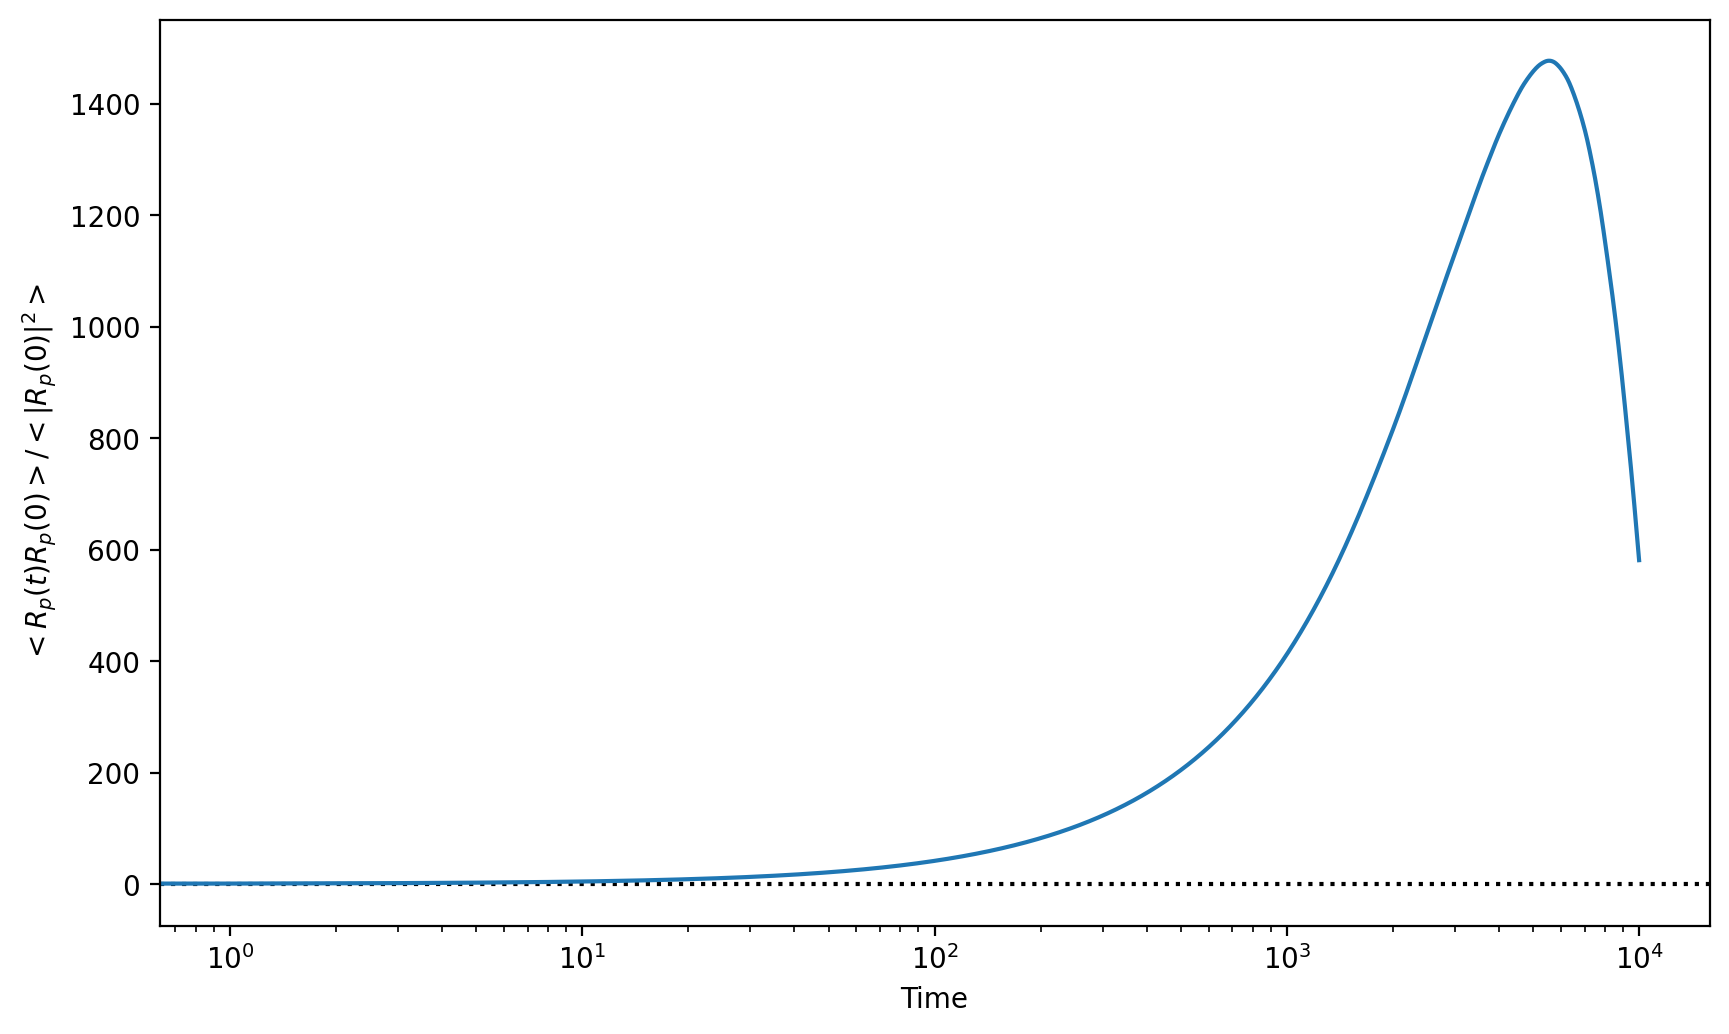

Wall time: 4min 38s


In [131]:
%%time

### This defines the variables for the simulation
N = 100 #number of masses
p = 1 #mode
T = 10 #temperature

mass = 1 # mass per particle (uniform)
k_b = 1 # Boltzmann constant
friction = 1 # friction constant
b = (3*k_b*np.pi**2/friction)**(1/2) # average bonding length
k = 3*k_b*T/(b**2)

amp = 1 #amplitude of noise
τ = 1 #correlation of noise

# Initialize particle positions, velocities, accelerations, and Wiener process
x = sp.random.uniform(0,L,size=N)
v = velocities(T)
acc = harmonic(x)
wiener = sp.random.uniform(0,1,N)

x_0 = np.copy(x)

# Mean square displacements
# msd = np.zeros(steps+1)
# msd[0] = 0

# tagged_1 = np.zeros(steps)
# tagged_2 = np.zeros(steps)
# tagged_3 = np.zeros(steps)

sw = amp*np.sin(math.sqrt(2/τ)*wiener)

# Initialize the Rouse arrays

r_top = np.zeros(steps+1)

# Give initial value to Rouse arrays
### For normalized ACF no change in bottom

r_top[0] = top_value(x,x_0,p)
denom = top_value(x_0,x_0,p)

for ts in range(1,steps+1):
    # change positions
    x += v*dt+0.5*(acc+sw)*dt2
#     tagged_1[ts-1] = x[4]
#     tagged_2[ts-1] = x[0]
#     tagged_3[ts-1] = x[9]
    
    r_top[ts] = top_value(x,x_0,p)
    
    # update 1st step velocities
    v += 0.5*(acc+sw)*(dt/friction)
    
    # update accelerations
    acc = harmonic(x)
    
    wiener += random(dt)
    sw = amp*np.sin(math.sqrt(2/τ)*wiener)
    
    # update 2nd step velocities
    v += 0.5*(acc+sw)*(dt/friction)
    
#     # update MSD
#     dx = 0
#     for i in range(N):
#         dx += x[i]-x_0[i]
        
#     msd[ts] = dx**2
    
# msd /= float(N)
r_top *= 1/denom

### This saves the data into a text file
np.savetxt("N100_p1_R1_T10_F1.txt",r_top)
# np.savetxt("MSD_N100_p4_R1_T10_F1.txt",msd)

fig = plt.figure(figsize=(10, 6), dpi=200)
ax = fig.add_subplot(111)

plt.axhline(y=0, color="black", linestyle=":")
plt.semilogx(r_top)
plt.xlabel('Time')
plt.ylabel('$<R_p(t)R_p(0)>/<|R_p(0)|^2>$')
plt.show()

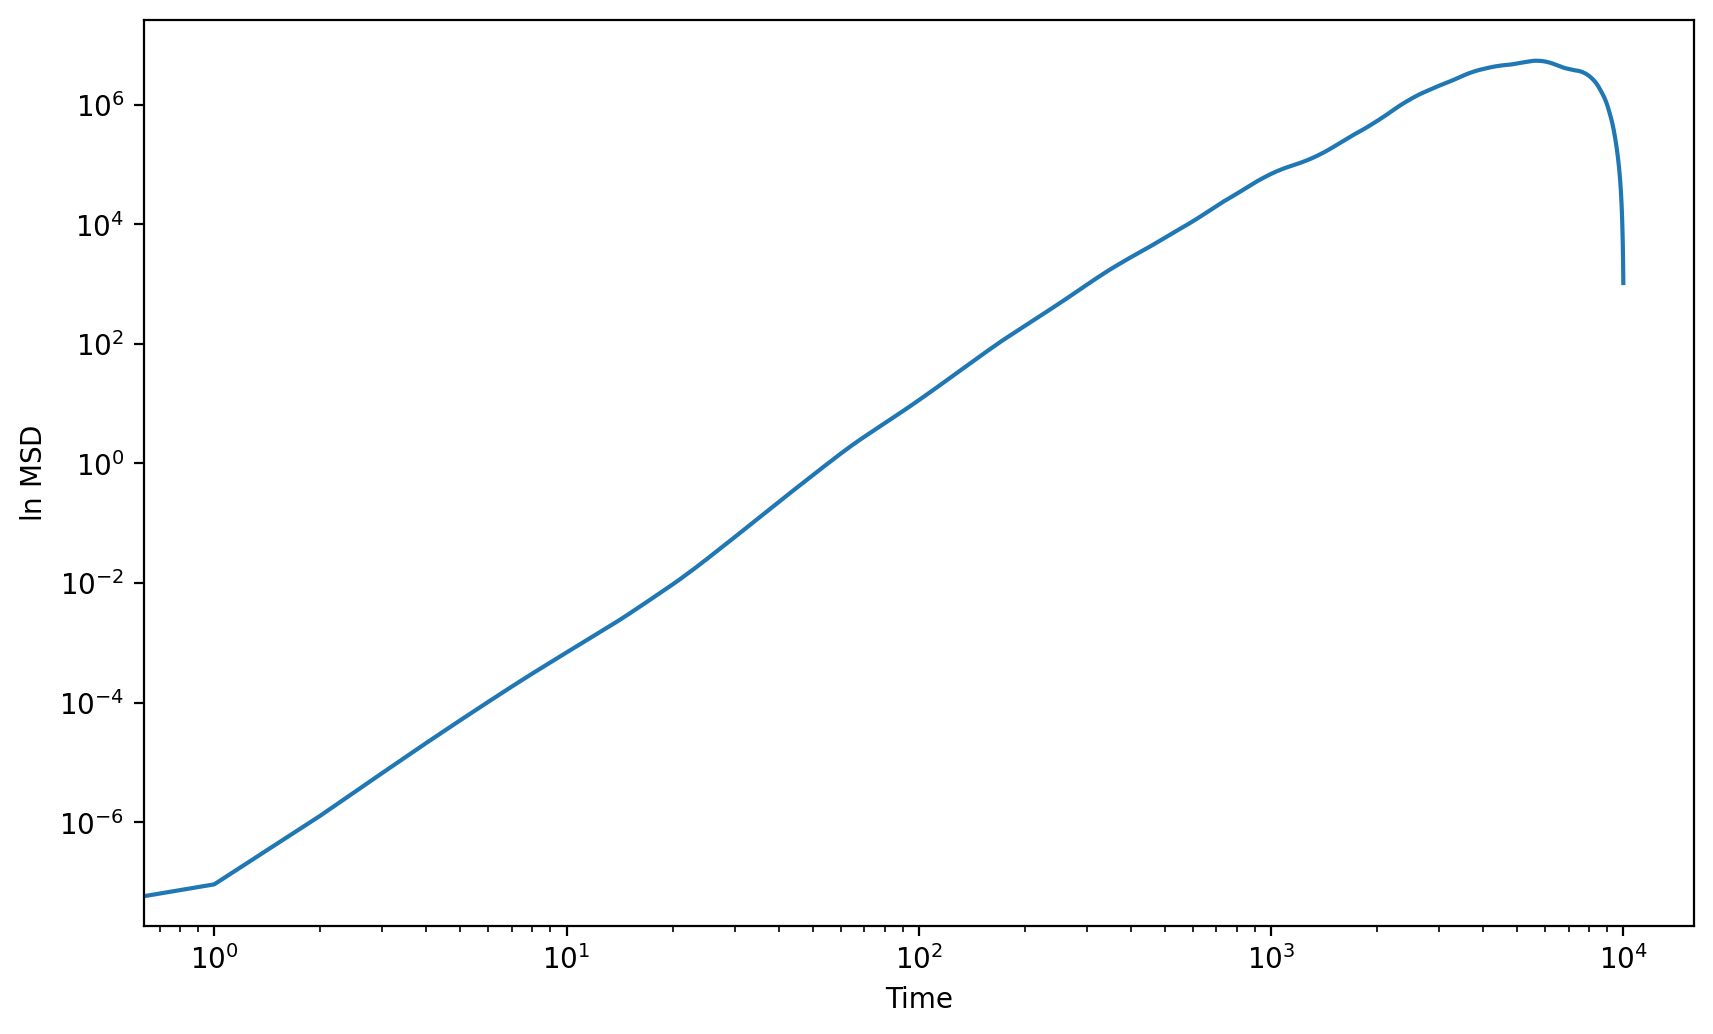

In [126]:
fig = plt.figure(figsize=(10, 6), dpi=200)
ax = fig.add_subplot(111)

# plt.axhline(y=0, color="black", linestyle=":")
plt.loglog(msd)
plt.xlabel('Time')
plt.ylabel('$\ln$ MSD')
plt.show()